In [1]:
import pandas as pd
from numble_data_preprocess import numble_preprocess, label_encoding
from collected_data_preprocess import nice_data_prepare, nice_combine, incruit_prepare, find_incruit_company
from financial_data_preprocess import make_financial_yeardata, delete_semi_active, delete_normal_active, delete_inactive, make_financial_column, replace_outlier, is_outlier

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 그래프에서 마이너스 폰트 깨지는 문제에 대한 대처
mpl.rcParams['axes.unicode_minus'] = False

# 2. Feature Selection 
- 재무데이터 상관관계보고 연관도 높은 feature + feature importance가 낮은 feature 우선순위로 drop

In [264]:
# 저장해둔 데이터 사용
final_data = pd.read_csv('../data/final_data.csv', index_col=0)

## 1) 재무데이터 상관관계 분석 (corr)

In [149]:
# 재무데이터 선택
corr_financial_df = final_data.iloc[:, 16:]

corrMatt = corr_financial_df.corr()
mask = np.array(corrMatt)
mask[np.tril_indices_from(mask)] = False

<AxesSubplot:>

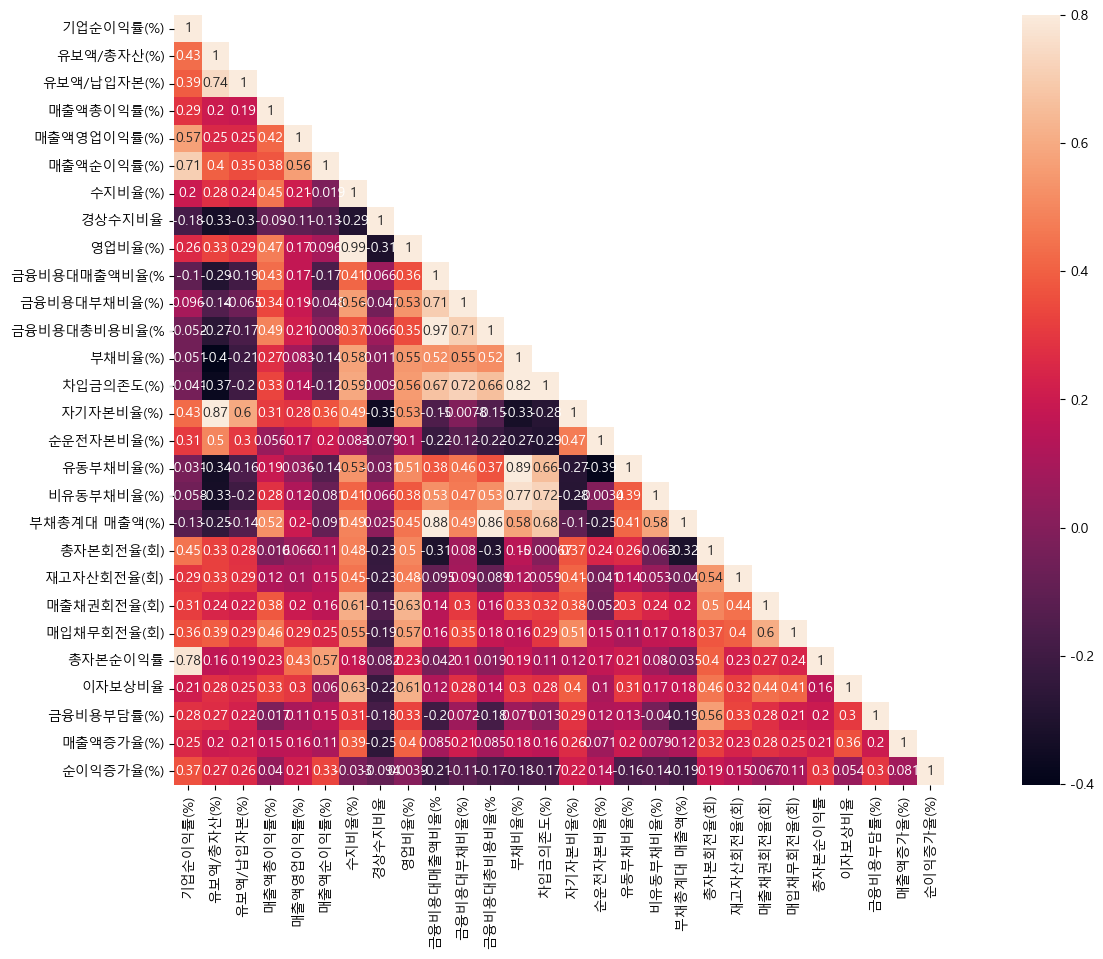

In [154]:
import seaborn as sns

# 상관관계 시각화
fig, ax = plt.subplots()
fig.set_size_inches(20,10)
sns.heatmap(corrMatt, mask=mask, vmax = .8, square=True, annot=True)

In [ ]:
# drop_feature
del_list = ['국가','설립구분','업종','벤처기업여부','중견기업보호여부','우수기업','상장여부','국외투자법인여부','수지비율', '자기자본비율','금융비용대총비용비율','유동비율']

## 2) feature importance
- with light gbm classifier

In [266]:
from sklearn.model_selection import train_test_split

X = final_data[final_data.columns.difference(['휴폐업이력'])]
y = final_data[['휴폐업이력']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [267]:
from lightgbm import LGBMClassifier

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
lgbm_wrapper = LGBMClassifier(n_estimators=4000)
lgbm_wrapper.fit(X_train, y_train,
                # 조기 중단 파라미터
                early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                verbose=True)

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\bin\anaconda3\envs\numble\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.433946
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.391979
[3]	valid_0's binary_logloss: 0.36001
[4]	valid_0's binary_logloss: 0.334456
[5]	valid_0's binary_logloss: 0.313372
[6]	valid_0's binary_logloss: 0.295253
[7]	valid_0's binary_logloss: 0.280089
[8]	valid_0's binary_logloss: 0.26686
[9]	valid_0's binary_logloss: 0.255232
[10]	valid_0's binary_logloss: 0.24518
[11]	valid_0's binary_logloss: 0.23637
[12]	valid_0's binary_logloss: 0.228574
[13]	valid_0's binary_logloss: 0.221817
[14]	valid_0's binary_logloss: 0.21593
[15]	valid_0's binary_logloss: 0.210739
[16]	valid_0's binary_logloss: 0.205719
[17]	valid_0's binary_logloss: 0.201361
[18]	valid_0's binary_logloss: 0.197654
[19]	valid_0's binary_logloss: 0.194414
[20]	valid_0's binary_logloss: 0.191341
[21]	valid_0's binary_logloss: 0.18884
[22]	valid_0's binary_logloss: 0.185754
[23]	valid_0's binary_logloss: 0.183462
[24]	valid_0's binary_logloss: 0.

LGBMClassifier(n_estimators=4000)

In [268]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)

    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [269]:
# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds, pred_proba)

importances = pd.Series(lgbm_wrapper.feature_importances_, X_train.columns)

정확도: 0.9491, 정밀도: 0.9112, 재현율: 0.8220, F1: 0.8643, AUC: 0.9743


<AxesSubplot:title={'center':'feature importance'}>

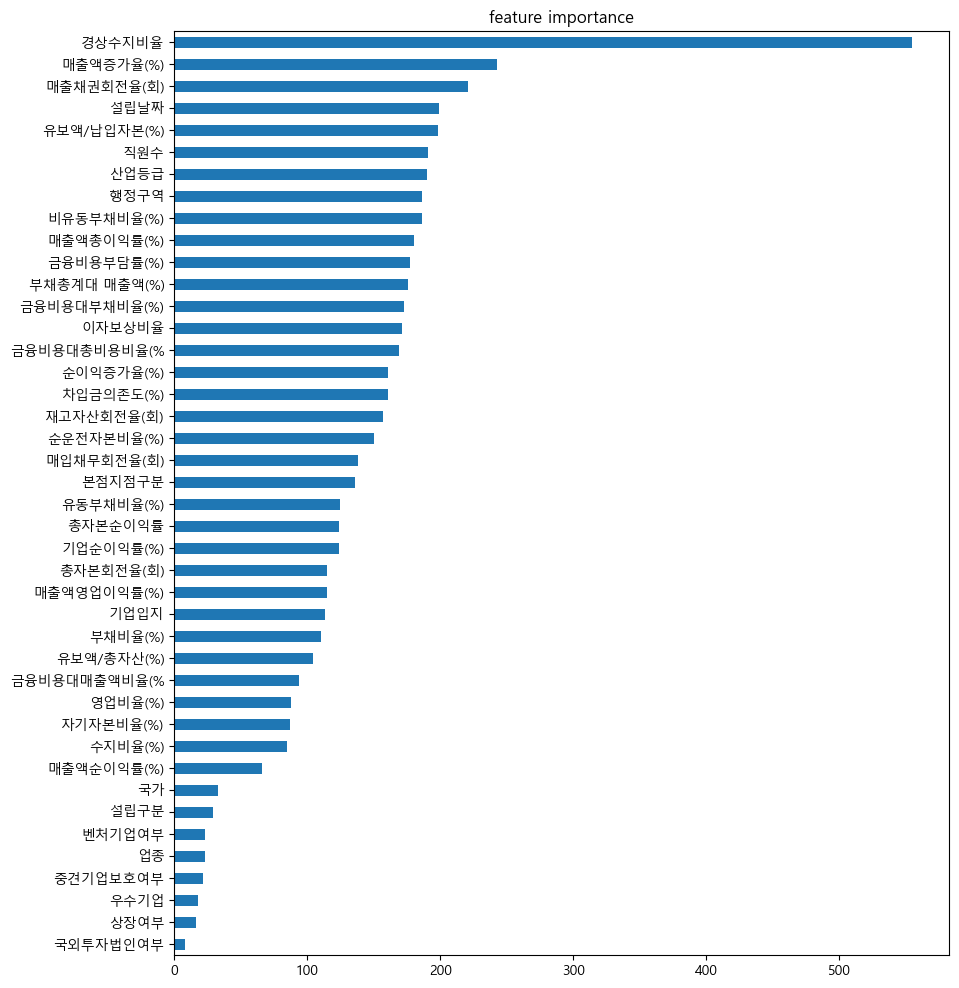

In [123]:
# feature importance 시각화

plt.figure(figsize=(10,12))
plt.title('feature importance')
importances.sort_values().plot.barh()

## 3) 연관관계와 feature importance 고려해서 feature selection



In [270]:
del_list = ['국가','설립구분','업종','벤처기업여부','중견기업보호여부','우수기업','상장여부','국외투자법인여부','수지비율(%)', '자기자본비율(%)','금융비용대총비용비율(%','부채비율(%)']

final_data.drop(del_list, axis=1, inplace=True)

In [271]:
from sklearn.model_selection import train_test_split

X = final_data[final_data.columns.difference(['휴폐업이력'])]
y = final_data[['휴폐업이력']]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=42)

In [272]:
from lightgbm import LGBMClassifier

# eval_set
evals = [ (X_test, y_test) ]

# 학습 (조기 중단 지정)
lgbm_wrapper = LGBMClassifier(n_estimators=4000)
lgbm_wrapper.fit(X_train, y_train,
                # 조기 중단 파라미터
                early_stopping_rounds = 100, eval_metric = "logloss", eval_set = evals, 
                verbose=True)

c:\Users\bin\anaconda3\envs\numble\lib\site-packages\sklearn\preprocessing\_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\bin\anaconda3\envs\numble\lib\site-packages\sklearn\preprocessing\_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[1]	valid_0's binary_logloss: 0.434293
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.391796
[3]	valid_0's binary_logloss: 0.360166
[4]	valid_0's binary_logloss: 0.334611
[5]	valid_0's binary_logloss: 0.313615
[6]	valid_0's binary_logloss: 0.296037
[7]	valid_0's binary_logloss: 0.280652
[8]	valid_0's binary_logloss: 0.267638
[9]	valid_0's binary_logloss: 0.256146
[10]	valid_0's binary_logloss: 0.245804
[11]	valid_0's binary_logloss: 0.23707
[12]	valid_0's binary_logloss: 0.229451
[13]	valid_0's binary_logloss: 0.222666
[14]	valid_0's binary_logloss: 0.216799
[15]	valid_0's binary_logloss: 0.21126
[16]	valid_0's binary_logloss: 0.206553
[17]	valid_0's binary_logloss: 0.202295
[18]	valid_0's binary_logloss: 0.198996
[19]	valid_0's binary_logloss: 0.195696
[20]	valid_0's binary_logloss: 0.192621
[21]	valid_0's binary_logloss: 0.189852
[22]	valid_0's binary_logloss: 0.18732
[23]	valid_0's binary_logloss: 0.185174
[24]	valid_0's binary_logloss:

LGBMClassifier(n_estimators=4000)

In [273]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba_po=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    auc = roc_auc_score(y_test, pred_proba_po)

    print(f"정확도: {accuracy:.4f}, 정밀도: {precision:.4f}, 재현율: {recall:.4f}, F1: {f1:.4f}, AUC: {auc:.4f}")

In [274]:
# 예측
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

# 평가
get_clf_eval(y_test, preds, pred_proba)

정확도: 0.9478, 정밀도: 0.9118, 재현율: 0.8142, F1: 0.8602, AUC: 0.9739


## 여러가지 알고리즘 비교
여러 알고리즘 비교

- decisionTreeClassifier
- randomforestclassifier
- lightGBM classifier



In [247]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier

estimators = [DecisionTreeClassifier(random_state=42),
             RandomForestClassifier(random_state=42),
             
             ]
estimators

[DecisionTreeClassifier(random_state=42),
 RandomForestClassifier(random_state=42)]

In [250]:
from sklearn.model_selection import RandomizedSearchCV

max_depth = np.random.randint(2, 20, 10)
max_features = np.random.uniform(0.3, 1.0, 10)

param_distributions = {'max_depth':max_depth, 
                       'max_features':max_features}

results=[]
for estimator in estimators:
    result=[]

    if estimator.__class__.__name__ != 'DecisionTreeClassifier':
        param_distributions['n_estimators'] = np.random.randint(100, 200, 10)
        
    clf = RandomizedSearchCV(estimator, 
                    param_distributions, 
                    n_iter=100, 
                    scoring='accuracy', 
                    n_jobs=-1,
                    cv=5,
                    verbose=2
                    )
    clf.fit(X_train, y_train)
    result.append(estimator.__class__.__name__)
    result.append(clf.best_params_)
    result.append(clf.best_score_)
    result.append(clf.score(X_test, y_test))
    result.append(clf.cv_results_)
    results.append(result)


Fitting 5 folds for each of 100 candidates, totalling 500 fits
Fitting 5 folds for each of 100 candidates, totalling 500 fits


c:\Users\bin\anaconda3\envs\numble\lib\site-packages\sklearn\model_selection\_search.py:910: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [252]:
pd.DataFrame(results, columns=['estimator', 'best_params', 'train_score', 'test_score', 'cv_result'])

,estimator,best_params,train_score,test_score,cv_result
0,DecisionTreeClassifier,"{'max_features': 0.9583057977644764, 'max_dept...",0.93,0.93,"{'mean_fit_time': [0.9139950275421143, 1.51619..."
1,RandomForestClassifier,"{'n_estimators': 181, 'max_features': 0.630262...",0.94,0.94,"{'mean_fit_time': [90.72719640731812, 65.05679..."
